# Music Recommender System


In [1]:
# import libraries
import pandas as pd
from tswift import Song
from tqdm import tqdm
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import math
from statistics import mean
import matplotlib.pyplot as plt
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import implicit # The Cython library
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split 
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model, load_model as keras_load_model
from keras import losses
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 1. Data Preparation
## 1.1 Reading Datasets

In [2]:
headList = ['userid','songid','playcounts']
df_user = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/Music_finalProject/kaggle_visible_evaluation_triplets.txt',
                      names = headList,
                      header = None,
                      sep = '\t',
                      encoding= 'utf-8',
                      engine='python')
df_user = df_user.dropna()

headList = ['songid','trackid']
df_SongToTrack = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/Music_finalProject/taste_profile_song_to_tracks.txt',
                             names = headList,
                             header = None,
                             sep = '\t',
                             encoding= 'utf-8',
                             engine='python')
df_SongToTrack = df_SongToTrack.dropna()

# Merging datasets of user and song to track on songid.
df_user = df_user.merge(df_SongToTrack,
                        on='songid')
df_user.drop('songid',axis=1,inplace=True)
df_user

,userid,playcounts,trackid
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1,TRAEHHJ12903CF492F
1,c34670d9c1718361feb93068a853cead3c95b76a,1,TRAEHHJ12903CF492F
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,1,TRAEHHJ12903CF492F
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,2,TRAEHHJ12903CF492F
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,4,TRAEHHJ12903CF492F
...,...,...,...
1436157,9d2f78e2bda5a004879d3ee53ee7de5cdf99c730,1,TRZHWHD128F42B9D11
1436158,987b654b09b239f7c47751e0cfaa2990834cbb55,1,TRNBQWA128F145DB74
1436159,987b654b09b239f7c47751e0cfaa2990834cbb55,3,TRIWGAI12903CDF710
1436160,fc072bde2043756ea30ff07e4a5311e34825b4df,1,TRMPODL128F4228DE1


In [3]:
headList = ['trackid','artistname','title', 'mxm trackid','mxm artistname','mxm title']
df_mix = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/Music_finalProject/mxm_779k_matches.txt', 
                     names = headList,
                     header = None,
                     delimiter='<SEP>',
                     encoding= 'utf-8',
                     engine='python')
df_meta = df_mix.iloc[:,:3].dropna()
df_meta

,trackid,artistname,title
0,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan
1,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever
2,TRMMMCH128F425532C,Yerba Brava,Si Vos Querés
3,TRMMMXN128F42936A5,David Montgomery,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All..."
4,TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall
...,...,...,...
779051,TRYYYZM128F428E804,SKYCLAD,Inequality Street
779052,TRYYYON128F932585A,Loose Shus,Taurus (Keenhouse Remix)
779053,TRYYYUS12903CD2DF0,Kiko Navarro,O Samba Da Vida
779054,TRYYYMG128F4260ECA,Gabriel Le Mar,Novemba


## 1.2 Subset dataset

In [4]:
# get the most 70 popular songs to save more computation time
track = df_user['trackid'].value_counts().sort_values(ascending=False).head(70)
df_meta = df_meta.loc[df_meta['trackid'].isin(track.index)]
print('df_user', df_user.shape)
print('df_meta', df_meta.shape)

df_user (1436162, 3)
df_meta (66, 3)


## 1.3 Getting Lyrics by tswift

https://github.com/brenns10/tswift

In [5]:
def getLyrics(songs):
    num = 0
    lyrics = []  
    Tol = len(songs)
    for title, artist, _ in zip(songs.title, songs.artistname, tqdm(range(Tol))):
        try:
            lyrics.append(Song(title=title, artist=artist).lyrics)
        except Exception:
            lyrics.append(None)
            pass  
    
    return lyrics
lyrics = getLyrics(df_meta)

 98%|████████████████████████████████████████████████████████████████████████████████▊ | 65/66 [00:20<00:00,  3.16it/s]


In [6]:
df_meta['lyrics'] = lyrics 
df_meta = df_meta.dropna()

In [7]:
clean_lyrics = []
for i in df_meta.lyrics:
    string = i.replace('\n',' ')
#     string = re.sub(r'[^a-zA-Z-\' ]','',string)
#     string = re.sub(r'[a-zA-Z\' ]+[-]+[\s]+','',string).strip()
    clean_lyrics.append(string)

df_meta['lyrics'] = clean_lyrics
df_meta['lyrics'].replace('', np.nan, inplace=True)

In [8]:
df_meta = df_meta.dropna().reset_index(drop=True)
df_meta.head(3)

,trackid,artistname,title,lyrics
0,TRHTCXG12903CC2F60,3 Doors Down,Kryptonite,I took a walk around the world To ease my trou...
1,TRRHGFY12903CD2DC8,Justin Bieber,Somebody To Love,"For you, I'd write a symphony I'd tell the vi..."
2,TRRUVLO128F92DE6F7,La Roux,Bulletproof,"Been there, done that messed around I'm having..."


In [9]:
def maximum(data):
    return np.max(data)

def minimum(data):
    return np.min(data)

def normalize(playcounts, minimum, maximum):
    return (playcounts - minimum) / (maximum - minimum)

def denormalize(normalized, minimum, maximum):
    return normalized * (maximum-minimum)+ minimum

In [10]:
df_user = df_user.loc[df_user['trackid'].isin(df_meta['trackid'])].reset_index(drop=True)

vc = df_user.userid.value_counts()
user_index = list(vc[vc>=5].index)
df_user = df_user[df_user.userid.isin(user_index)].reset_index(drop=True)

# adding rating columns based on playcount
df_user['ratings'] = np.nan
for user in tqdm((df_user.userid.unique())):
    df_user_play = df_user[df_user['userid'].isin([user])]
    min = minimum(df_user_play['playcounts'])
    max = maximum(df_user_play['playcounts'])
    norm = normalize(df_user_play['playcounts'],min,max)
    ind = norm.index
    df_user.loc[ind, 'ratings'] = norm
    df_user.fillna(0, inplace=True)


100%|███████████████████████████████████████████████████████████████████████████████| 835/835 [00:02<00:00, 337.21it/s]


In [11]:
df_meta.to_csv('music_meta.csv', sep=',', encoding='utf-8')
df_user.to_csv('music_user.csv', sep=',', encoding='utf-8')

In [12]:
df_user = pd.read_csv('music_user.csv', index_col = 0)
df_meta = pd.read_csv('music_meta.csv', index_col = 0)


In [13]:
df_meta.head(3)

,trackid,artistname,title,lyrics
0,TRHTCXG12903CC2F60,3 Doors Down,Kryptonite,I took a walk around the world To ease my trou...
1,TRRHGFY12903CD2DC8,Justin Bieber,Somebody To Love,"For you, I'd write a symphony I'd tell the vi..."
2,TRRUVLO128F92DE6F7,La Roux,Bulletproof,"Been there, done that messed around I'm having..."


In [14]:
df_user.head(3)

,userid,playcounts,trackid,ratings
0,55a653641aa684a958e01a49442c6d4da2badd8d,3,TRAEHHJ12903CF492F,0.5
1,16ca2088a2ec137cf4597a2b3e2e0136930af8a1,6,TRAEHHJ12903CF492F,1.0
2,9f7323adccc61db1c261acf97e2468f776faaf8f,1,TRAEHHJ12903CF492F,0.0


In [15]:
df_meta["text"] = df_meta["artistname"] + " " + df_meta["title"] +" "+ df_meta["lyrics"]
df_meta.head(3)

,trackid,artistname,title,lyrics,text
0,TRHTCXG12903CC2F60,3 Doors Down,Kryptonite,I took a walk around the world To ease my trou...,3 Doors Down Kryptonite I took a walk around t...
1,TRRHGFY12903CD2DC8,Justin Bieber,Somebody To Love,"For you, I'd write a symphony I'd tell the vi...","Justin Bieber Somebody To Love For you, I'd wr..."
2,TRRUVLO128F92DE6F7,La Roux,Bulletproof,"Been there, done that messed around I'm having...","La Roux Bulletproof Been there, done that mess..."


In [16]:
df_meta_all = df_meta[['trackid', 'text', 'title']]

## 1.3 Data Cleaning by Using NLP

In [17]:
import string
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2    
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    clean_text = [wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)
df_meta_all['text'] = df_meta_all['text'].apply(clean_txt)
meta_final = df_meta_all

In [18]:
meta_final.head(3)

,trackid,text,title
0,TRHTCXG12903CC2F60,doors kryptonite take walk around world ease t...,Kryptonite
1,TRRHGFY12903CD2DC8,justin bieber somebody love write symphony tel...,Somebody To Love
2,TRRUVLO128F92DE6F7,roux bulletproof mess around fun n't put 'll n...,Bulletproof


### 1.3.1 EDA and do the deep cleaning

In [19]:
cv = CountVectorizer()
data_cv = cv.fit_transform(meta_final.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = meta_final.trackid
data = data_dtm.transpose()
data.head(3)

trackid,TRHTCXG12903CC2F60,TRRHGFY12903CD2DC8,TRRUVLO128F92DE6F7,TRBZGSM128E078EDB4,TRQFXKD128E0780CAE,TRZJNDO128EF343498,TRIEXMF128F92FDD60,TRIXAZF128F421EE64,TRIKGRK128E0780DB0,TRAALAH128E078234A,...,TRSDRPY128F933E202,TROMKCG128F9320C09,TROAQBZ128F9326213,TRONBHE128F92D6309,TRONYHY128F92C9D11,TRXWAZC128F9314B3E,TRKRRUV128F92F20F1,TRKBJPL12903CED195,TRYNJBB128F931A7EE,TRYVBMA128E0789D39
21st,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
across,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
admit,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Find the top 30 words by each track
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

# Print the top 15 words by each track
for track, top_words in top_dict.items():
    print(track)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

TRHTCXG12903CC2F60
side, whoa, call, still, kryptonite, keep, ll, alive, might, superhuman, well, crazy, hand, superman
---
TRRHGFY12903CD2DC8
somebody, need, love, give, else, swear, promise, girl, much, find, every, lot, world, beat
---
TRRUVLO128F92DE6F7
ll, time, bulletproof, baby, let, tick, around, turn, tell, feet, away, something, much, mess
---
TRBZGSM128E078EDB4
cause, back, na, without, little, get, empty, guess, like, feel, controversy, job, everybody, round
---
TRQFXKD128E0780CAE
ooh, say, back, tell, easy, nobody, come, start, apart, science, tail, run, question, one
---
TRZJNDO128EF343498
ll, oh, yo, world, know, make, disappear, far, melt, fear, away, storm, stop, path
---
TRIEXMF128F92FDD60
somebody, someone, like, ooo, know, use, could, ready, make, ve, see, gon, around, look
---
TRIXAZF128F421EE64
one, dream, gun, never, dense, light, twice, turn, need, make, tragedy, present, book, seem
---
TRIKGRK128E0780DB0
look, shine, yellow, skin, know, yeah, turn, thing, thing

In [21]:
# Let's first pull out the top 30 words for each track
words = []
for track in data.columns:
    top = [word for (word, count) in top_dict[track]]
    for t in top:
        words.append(t)
        
# Let's aggregate this list and identify the most common words along with how many routines they occur in
Counter(words).most_common()   

# If more than 10 of the track have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count > 10]
add_stop_words

['know', 'get', 'like', 'll', 'love']

In [22]:
# Look at the most common top words --> add them to the stop word list
# Add new stop words
stop_words_ = set(stopwords.words('english')).union(add_stop_words)
df_meta_all['text'] = df_meta_all['text'].apply(clean_txt)
meta_final = df_meta_all

In [23]:
meta_final.head()

,trackid,text,title
0,TRHTCXG12903CC2F60,doors kryptonite take walk around world ease t...,Kryptonite
1,TRRHGFY12903CD2DC8,justin bieber somebody write symphony tell vio...,Somebody To Love
2,TRRUVLO128F92DE6F7,roux bulletproof mess around fun n't put 'll n...,Bulletproof
3,TRBZGSM128E078EDB4,eminem without obie trice real name gimmicks t...,Without Me
4,TRQFXKD128E0780CAE,coldplay scientist come meet tell sorry n't lo...,The Scientist


### 1.3.2 Plot the Songs Word Cloud 

In [24]:
# Let's make some word clouds!
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud

cv = CountVectorizer()
data_cv = cv.fit_transform(meta_final.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = meta_final.trackid
data = data_dtm.T
wc = WordCloud(stopwords=stop_words_, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

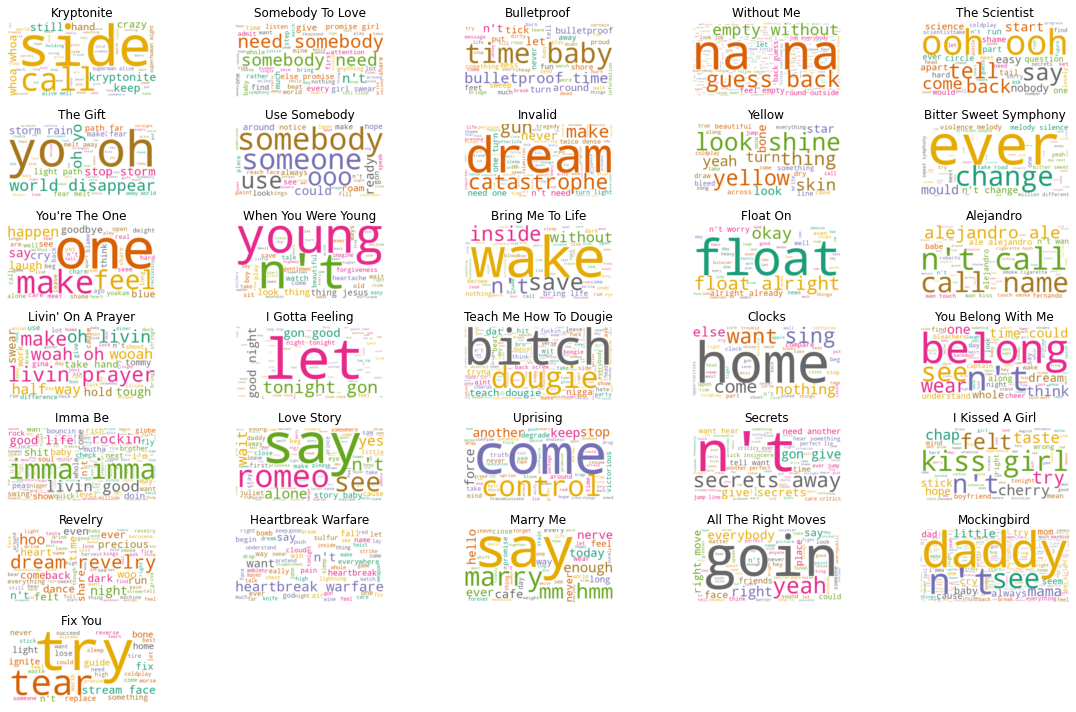

In [25]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [16, 10]

# Create subplots for each track
for index, track in enumerate(data.columns):
    row = list(meta_final[meta_final.trackid == track].index)[0]
    wc.generate(meta_final.text[row])
    
    plt.subplot(7, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(meta_final.title[row])

plt.tight_layout()
plt.show()

## 1.4 Creating the User Corpus

In [26]:
user_text = []
for user, _ in zip(df_user['userid'].unique(),tqdm(range(len(df_user['userid'].unique())))):
    user_playlist = (df_user.loc[df_user['userid'].isin([user])])
    user_text.append(' '.join(df_meta.loc[df_meta['trackid'].isin(user_playlist['trackid'])]['text']))


100%|██████████████████████████████████████████████████████████████████████████████▉| 834/835 [00:00<00:00, 953.51it/s]


In [27]:
user_final = pd.DataFrame(df_user['userid'].unique(),columns = ['userid'])
user_final['text'] = user_text

# it takes about 6 mins to compute
user_final['text'] = user_final['text'].apply(clean_txt)
user_final

,userid,text
0,55a653641aa684a958e01a49442c6d4da2badd8d,roux bulletproof mess around fun n't put 'll n...
1,16ca2088a2ec137cf4597a2b3e2e0136930af8a1,roux bulletproof mess around fun n't put 'll n...
2,9f7323adccc61db1c261acf97e2468f776faaf8f,coldplay yellow look star look shine everythin...
3,39fc236a3f13ff85d27b6e9e80a40ce7bf683b27,justin bieber somebody write symphony tell vio...
4,1ce57ca4746bce45d7bc3732aca5bdf3262d33be,justin bieber somebody write symphony tell vio...
...,...,...
830,9a8df8014b085526495e694747245b8218375635,justin bieber somebody write symphony tell vio...
831,71f324c0af5ef4e014a1e7900cdcce6772c23fd5,justin bieber somebody write symphony tell vio...
832,89df78d6c28b7f3815add415004a3f166a1049e1,lady gaga alejandro young may n't anymore alej...
833,ae0764ccd3ca1d49091c06d328495172194179d0,evanescence bring life see eye open doors lead...


In [28]:
meta_final.to_csv('music_meta_final.csv', sep=',', encoding='utf-8')
user_final.to_csv('music_user_final.csv', sep=',', encoding='utf-8')

In [29]:
df_user_final = pd.read_csv('music_user_final.csv', index_col = 0)
df_meta_final = pd.read_csv('music_meta_final.csv', index_col = 0)

# 2. Building Recommender System
## 2.1 Content-based Filtering (CBF)

### 2.1.1 TF-IDF ( Term Frequency - Inverse Document Frequency )

In [30]:
#initializing tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()

music_tfidf_matrix  = tfidf_vectorizer.fit_transform((meta_final['text'])) #fitting and transforming the vector
music_tfidf_df = pd.DataFrame(music_tfidf_matrix.toarray())
print(music_tfidf_df.shape)

(31, 1210)


## 2.1.2 Evaluate system

In [31]:
def score_to_counts(list_scores, userid):
    min_score = minimum(list_scores)
    max_score = maximum(list_scores)
    list_scores = list_scores/(max_score-min_score)
    where_are_NaNs = np.isnan(list_scores)
    list_scores[where_are_NaNs] = 0
    
    df_user_play = df_user[df_user['userid'].isin([userid])]
    min = minimum(df_user_play['playcounts'])
    max = maximum(df_user_play['playcounts'])
    list_scores = denormalize(list_scores, min, max)
    return list_scores, df_user_play

In [32]:
def evaluation(df):
    df_pre = pd.DataFrame(columns = ['playcounts', 'pre_playcounts'])#
    for userid in tqdm((df_user.userid.unique())):
        recommendation = pd.DataFrame(columns = ['userid', 'trackid', 'title', 'pred_playCounts'])
        count = 0
        user_index = np.where(df_user_final['userid']== userid)[0][0]
        user = df_user_final.iloc[[user_index]]
        
        # TF-IDF ( Term Frequency - Inverse Document Frequency )
        user_tfidf_matrix = tfidf_vectorizer.transform(user['text'])
        user_cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf_matrix, x),music_tfidf_matrix)
        output = list(user_cos_similarity_tfidf)

        # Function to get the top-N recomendations order by score
        top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)
        list_scores = np.array([output[i][0][0] for i in top])
        list_scores, df_user_play = score_to_counts(list_scores, userid)

        for i in top:
            recommendation.at[count, 'userid'] = userid
            recommendation.at[count, 'trackid'] = df['trackid'][i]
            recommendation.at[count, 'title'] = df['title'][i]
            recommendation.at[count, 'pred_playCounts'] =  list_scores[count]
            count += 1

        # recommend musics for users that listened
        u_song_list = df_user[df_user['userid'] == userid]['trackid']
        recommendation = recommendation[recommendation['trackid'].isin(u_song_list)].dropna()
        df_user_play['pre_playcounts'] = recommendation['pred_playCounts'].values
        
        df_pre = df_pre.append(df_user_play[['playcounts', 'pre_playcounts']], ignore_index=True)
    rms = mean_squared_error(df_pre['playcounts'], df_pre['pre_playcounts'], squared=False)    
    return rms, df_pre
rms, df_pre = evaluation(df_meta)
rms

100%|████████████████████████████████████████████████████████████████████████████████| 835/835 [00:40<00:00, 20.73it/s]


7.324473212859345

### 2.1.3 Recommend Songs for User

In [33]:
def get_recommendation(userid,Top_N, df):
    recommendation = pd.DataFrame(columns = ['trackid', 'pred_playCounts'])
    count = 0
    user_index = np.where(df_user_final['userid']== userid)[0][0]
    user = df_user_final.iloc[[user_index]]
    
    # TF-IDF ( Term Frequency - Inverse Document Frequency )
    user_tfidf_matrix = tfidf_vectorizer.transform(user['text'])
    user_cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf_matrix, x),music_tfidf_matrix)
    output = list(user_cos_similarity_tfidf)
    
    # Function to get the top-N recomendations order by score
    top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)
    list_scores = np.array([output[i][0][0] for i in top])
    list_scores, df_user_play = score_to_counts(list_scores, userid)

    for i in top:
        recommendation.at[count, 'trackid'] = df['trackid'][i]
        recommendation.at[count, 'title'] = df['title'][i]
        recommendation.at[count, 'pred_playCounts'] =  list_scores[count]
        count += 1
    #display(recommendation)
    # recommend musics for users that haven't been listened
    u_song_list = df_user[df_user['userid'] == userid]['trackid']
    recommendation = recommendation[~recommendation['trackid'].isin(u_song_list)].dropna()
    recommendation = recommendation[:Top_N].set_index('trackid')#.merge(df_meta[['trackid','artistname']], on = 'trackid')[['userid','trackid','artistname','title','pred_playCounts']]
    
    return recommendation

In [34]:
df_user_test = df_user.userid.value_counts().loc[lambda x: x>=8].rename_axis('userid').reset_index(name='counts')
userid = '63030d4e314e339a4609607fa7b96370cc94317b'#df_user_test.sample(n = 1)['userid'].values[0]
Top_N=8
print('Top ', Top_N,' music recommend for user ',userid)
display(get_recommendation(userid,Top_N,df_meta))
print('\n')
print('Music that user ',userid,' has listened')
# check the list that user has listened
u_song_list = df_user[df_user['userid'] == userid].merge(df_meta[['trackid','artistname','title']], on = 'trackid')
display(u_song_list)

Top  8  music recommend for user  63030d4e314e339a4609607fa7b96370cc94317b


,pred_playCounts,title
trackid,,
TRSDRPY128F933E202,2.991292,Love Story
TRIXAZF128F421EE64,2.787485,Invalid
TRBZGSM128E078EDB4,2.679351,Without Me
TRYNJBB128F931A7EE,2.645423,Mockingbird
TRENTGL128E0780C8E,2.338198,Clocks
TRZJNDO128EF343498,2.331665,The Gift
TRJPXVB128F9316916,2.270629,You Belong With Me
TROMKCG128F9320C09,2.267569,Uprising




Music that user  63030d4e314e339a4609607fa7b96370cc94317b  has listened


,userid,playcounts,trackid,ratings,artistname,title
0,63030d4e314e339a4609607fa7b96370cc94317b,11,TROAQBZ128F9326213,1.0,OneRepublic,Secrets
1,63030d4e314e339a4609607fa7b96370cc94317b,5,TRIEXMF128F92FDD60,0.4,Kings Of Leon,Use Somebody
2,63030d4e314e339a4609607fa7b96370cc94317b,9,TRKRRUV128F92F20F1,0.8,Train,Marry Me
3,63030d4e314e339a4609607fa7b96370cc94317b,5,TRQFXKD128E0780CAE,0.4,Coldplay,The Scientist
4,63030d4e314e339a4609607fa7b96370cc94317b,1,TRXWAZC128F9314B3E,0.0,John Mayer,Heartbreak Warfare
5,63030d4e314e339a4609607fa7b96370cc94317b,2,TRYVBMA128E0789D39,0.1,Coldplay,Fix You
6,63030d4e314e339a4609607fa7b96370cc94317b,2,TRRUVLO128F92DE6F7,0.1,La Roux,Bulletproof
7,63030d4e314e339a4609607fa7b96370cc94317b,4,TRRHGFY12903CD2DC8,0.3,Justin Bieber,Somebody To Love


In [35]:
# Load data
df_user = pd.read_csv('music_user.csv', index_col = 0)
df_meta = pd.read_csv('music_meta.csv', index_col = 0)

## Application

### Recommend Songs for New User (Solving Cold Start Problem)

In [36]:
def NewUser(title_list, userid):
    global df_user_final, df_user
    text = (' '.join(df_meta[(df_meta['title'].isin(title_list))]['lyrics']))
    if userid not in df_user_final['userid'].values:
        for song in title_list:
            # search the trackid by title
            trackid = df_meta[df_meta['title']==song]['trackid'].values[0]
            # Let's say the playcounts of song that the user likes is 1, ratings is 1
            df_user = df_user.append({'userid':userid, 'playcounts':1, 'trackid':trackid, 'ratings': 0},ignore_index=True)

        df_user_final = df_user_final.append({'userid': userid,'text': text},ignore_index=True)
        user_index = int(df_user_final[df_user_final['userid']==userid].index.values)
        df_user_final.iloc[user_index]['text'] = clean_txt(df_user_final.iloc[user_index]['text'])
    else:
        
        for song in title_list:
            # search the trackid by title
            trackid = df_meta[df_meta['title']==song]['trackid'].values[0]
            user_tracks = df_user[df_user['userid']==userid]
            # the track has listened before
            if trackid in user_tracks['trackid'].values:
                play_index = int(user_tracks[user_tracks['trackid'] == trackid].index.values)
                df_user.loc[play_index,'playcounts']+=1
            else:
                df_user = df_user.append({'userid':userid, 'playcounts':1, 'trackid':trackid, 'ratings': 0},ignore_index=True)
                user_index = int(df_user_final[df_user_final['userid']==userid].index.values)
                new_text = df_meta[(df_meta['trackid']==trackid)]['lyrics'].values[0]
                df_user_final.iloc[user_index]['text'] += clean_txt(new_text)

        df_user_play = df_user[df_user['userid']==userid]
        min = minimum(df_user_play['playcounts'])
        max = maximum(df_user_play['playcounts'])
        norm = normalize(df_user_play['playcounts'],min,max)
        ind = norm.index
        df_user.loc[ind, 'ratings'] = norm
        df_user.fillna(0, inplace=True)
            
    # content based recommend        
    rec = get_recommendation(userid,8,df_meta)
    return rec[~(rec['title'].isin(title_list))].reset_index(drop=True) #, index = True

In [37]:
NewUser(['I Kissed A Girl','Somebody To Love','Invalid'],'xiaolan')

,pred_playCounts,title
0,1.0,Use Somebody
1,1.0,Secrets
2,1.0,Without Me
3,1.0,Mockingbird
4,1.0,Revelry
5,1.0,You're The One
6,1.0,Fix You
7,1.0,You Belong With Me


## 2.2 Collaborative filtering (CF) (Memory-based Approach)
### 2.2.1 Item_based 

In [38]:
userRatings = df_user.pivot_table(index=['userid'],columns=['trackid'],values='ratings')
userRatings.head(3)

trackid,TRAALAH128E078234A,TRAEHHJ12903CF492F,TRBZGSM128E078EDB4,TREBDEB12903CC0C56,TREMDNV12903CAC420,TRENTGL128E0780C8E,TRHTCXG12903CC2F60,TRIEXMF128F92FDD60,TRIKGRK128E0780DB0,TRIXAZF128F421EE64,...,TRQFXKD128E0780CAE,TRRHGFY12903CD2DC8,TRRUVLO128F92DE6F7,TRSDRPY128F933E202,TRSUSWW128F93463BF,TRUFTBY128F93450B8,TRXWAZC128F9314B3E,TRYNJBB128F931A7EE,TRYVBMA128E0789D39,TRZJNDO128EF343498
userid,,,,,,,,,,,,,,,,,,,,,
0027476f23f148ac89294f27602f49668e5a5b60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN
005a6d3db8263c1b08cb04b4e78c689dbb7ba6f5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00e1946778997bfb860e3cb1dedfcdf487df9d67,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
corrMatrix = userRatings.corr(method='pearson').fillna(0)
corrMatrix.head(3)

trackid,TRAALAH128E078234A,TRAEHHJ12903CF492F,TRBZGSM128E078EDB4,TREBDEB12903CC0C56,TREMDNV12903CAC420,TRENTGL128E0780C8E,TRHTCXG12903CC2F60,TRIEXMF128F92FDD60,TRIKGRK128E0780DB0,TRIXAZF128F421EE64,...,TRQFXKD128E0780CAE,TRRHGFY12903CD2DC8,TRRUVLO128F92DE6F7,TRSDRPY128F933E202,TRSUSWW128F93463BF,TRUFTBY128F93450B8,TRXWAZC128F9314B3E,TRYNJBB128F931A7EE,TRYVBMA128E0789D39,TRZJNDO128EF343498
trackid,,,,,,,,,,,,,,,,,,,,,
TRAALAH128E078234A,1.000000,-0.402513,0.257297,-0.191197,-0.333382,0.015822,-0.238437,0.197435,-0.036933,-0.465853,...,0.227411,0.143862,0.262909,-0.242536,0.304848,0.750163,0.280519,-0.727607,-0.029926,0.682927
TRAEHHJ12903CF492F,-0.402513,1.000000,-0.631204,-0.382330,-0.360999,-0.350941,-0.555810,-0.467665,-0.487295,0.015393,...,-0.266830,-0.137387,-0.563210,-0.155523,-0.393112,-0.469743,-0.139961,-0.503003,-0.191767,-0.056545
TRBZGSM128E078EDB4,0.257297,-0.631204,1.000000,-0.586515,0.128248,0.015754,0.371506,-0.298876,0.124692,-0.373822,...,-0.173977,-0.431276,0.085298,-0.317024,0.715966,-0.071442,0.298757,0.380906,0.181216,-1.000000


#### 2.2.1.1 Algorithm - Predict Ratings for Items
The method I use to predict the rating for specific user and item is as below, where K is the neighborhood of most similar items rated by active user a, and w(i,j) is the similarity between items i and j.

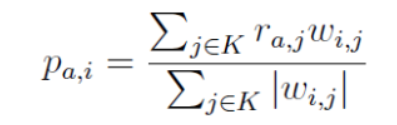

#### 2.2.1.2 Evaluate System

In [40]:
def evaluate():
    df_predict = pd.DataFrame()
    for user_i in tqdm(userRatings.index):
        myRatings = userRatings.loc[user_i].dropna()
        original_index = len(df_predict)
        
        for track_i in list(myRatings.index):
            # retrieve similar songs for movie i
            similar_track = corrMatrix[track_i]
            
            # substract to similar score between movie i and rated movies
            similar_track = similar_track[similar_track.index.isin(myRatings.index)].sort_values(ascending=False)#[1:4]
            
            # calculate predict rating
            # adding 0.01 to avoid 0 similar score in low number of ratings system
            predict_ratings = sum(myRatings[myRatings.index.isin(similar_track.index)].reindex(similar_track.index) * similar_track)/(sum(np.abs(similar_track)))
           
            df_predict = df_predict.append([[user_i, track_i,predict_ratings]])
            
        new_index = len(df_predict)
        
        df_predict.iloc[original_index:new_index,2], _ = score_to_counts(df_predict.iloc[original_index:new_index,2], user_i)
        
        
    df_predict.columns = ['userid','trackid','pred_playcounts']
    df_predict.reset_index(drop=True,inplace=True)
    df_predict = df_predict.merge(df_user, on=['userid','trackid'])
    

    # evaluate rms
    cf_rms = mean_squared_error(df_predict['playcounts'], df_predict['pred_playcounts'], squared=False)
    return cf_rms


#### 2.2.1.3 Recommend Songs for User

In [41]:
def recommend_songs(user_id, hm):
    myRatings = userRatings.loc[user_id].dropna()
    similar_candidates = pd.DataFrame()
    for i in list(corrMatrix.index):
        # retrieve similar songs for songs i
        similar_track = corrMatrix[i]
        # substract to similar score between songs i and rated songs
        similar_track = similar_track[similar_track.index.isin(myRatings.index)]
        # calculate predict rating
        predict_ratings = sum(myRatings * similar_track)/(sum(np.abs(similar_track))+0.01)
        similar_candidates = similar_candidates.append([predict_ratings])
    similar_candidates.iloc[:,0],_ = score_to_counts(similar_candidates.iloc[:,0], user_id)
    similar_candidates.index = corrMatrix.index
    # substract recommend songs that  have rated
    similar_candidates = similar_candidates[~similar_candidates.index.isin(myRatings.index)]
    similar_candidates.columns = ['pred_playcounts']
    similar_candidates.sort_values(by='pred_playcounts',inplace=True,ascending=False)    
    return similar_candidates[:hm]
# recommend songs for user_id 
rec_songs = recommend_songs(user_id='xiaolan',hm=10)
rec_songs

,pred_playcounts
trackid,
TRAALAH128E078234A,1.0
TRAEHHJ12903CF492F,1.0
TRYVBMA128E0789D39,1.0
TRYNJBB128F931A7EE,1.0
TRXWAZC128F9314B3E,1.0
TRUFTBY128F93450B8,1.0
TRSUSWW128F93463BF,1.0
TRSDRPY128F933E202,1.0
TRRUVLO128F92DE6F7,1.0


In [42]:
print('recommend track id are', list(rec_songs.index))

recommend track id are ['TRAALAH128E078234A', 'TRAEHHJ12903CF492F', 'TRYVBMA128E0789D39', 'TRYNJBB128F931A7EE', 'TRXWAZC128F9314B3E', 'TRUFTBY128F93450B8', 'TRSUSWW128F93463BF', 'TRSDRPY128F933E202', 'TRRUVLO128F92DE6F7', 'TRQFXKD128E0780CAE']


### 2.2.2 User_based

In [43]:
userRatings = df_user.pivot_table(index=['trackid'],columns=['userid'],values='ratings')
userRatings.head(3)

userid,0027476f23f148ac89294f27602f49668e5a5b60,005a6d3db8263c1b08cb04b4e78c689dbb7ba6f5,00e1946778997bfb860e3cb1dedfcdf487df9d67,00ef6009db7c64de797076fc8362fe9c1d4d2d66,01047b99e00bb0743f66bb321bdd62e38fddb0a5,010655660562dff97c4c99cded3b09952eb9da0b,013e798510337164b03d7f91aeb97c21fb26385a,0198834863361ec5074b25b9115ec1140ed1ba26,01b034d3ead54605aee0b48a01c07129569fb322,029182fe97b19cb6f11b858cd1febdb1bbcebbe5,...,fdcddcca68de2d92728a3262505078f94ba7fc86,fe6841c83fd3ae8e74b71fb087c7ddae2ab238e1,feff74ea7476acedd9e3a2cba10363b949d57685,ff125cc7b865c5be00d6a1d2a4e0984278cdddc4,ff30c9ddaf0fd5f83b01f2e903fc14d3f7b99099,ff80830a101547b5c112e72e939dde33f0a68a1b,ffa67f025a4f2e1409763c4d80b4f8bc55fd2ace,fff4438f5d96c5ecd66678f2a22fd7bbed59625f,fffd0a1b26c37a55574d844277d176991d054f99,xiaolan
trackid,,,,,,,,,,,,,,,,,,,,,
TRAALAH128E078234A,NaN,NaN,NaN,NaN,NaN,NaN,0.045455,NaN,0.333333,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRAEHHJ12903CF492F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
TRBZGSM128E078EDB4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
corrMatrix = userRatings.corr(method='pearson').fillna(0)
corrMatrix.head(3)

userid,0027476f23f148ac89294f27602f49668e5a5b60,005a6d3db8263c1b08cb04b4e78c689dbb7ba6f5,00e1946778997bfb860e3cb1dedfcdf487df9d67,00ef6009db7c64de797076fc8362fe9c1d4d2d66,01047b99e00bb0743f66bb321bdd62e38fddb0a5,010655660562dff97c4c99cded3b09952eb9da0b,013e798510337164b03d7f91aeb97c21fb26385a,0198834863361ec5074b25b9115ec1140ed1ba26,01b034d3ead54605aee0b48a01c07129569fb322,029182fe97b19cb6f11b858cd1febdb1bbcebbe5,...,fdcddcca68de2d92728a3262505078f94ba7fc86,fe6841c83fd3ae8e74b71fb087c7ddae2ab238e1,feff74ea7476acedd9e3a2cba10363b949d57685,ff125cc7b865c5be00d6a1d2a4e0984278cdddc4,ff30c9ddaf0fd5f83b01f2e903fc14d3f7b99099,ff80830a101547b5c112e72e939dde33f0a68a1b,ffa67f025a4f2e1409763c4d80b4f8bc55fd2ace,fff4438f5d96c5ecd66678f2a22fd7bbed59625f,fffd0a1b26c37a55574d844277d176991d054f99,xiaolan
userid,,,,,,,,,,,,,,,,,,,,,
0027476f23f148ac89294f27602f49668e5a5b60,1.000000,0.0,-0.654654,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,-1.000000,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,0.0
005a6d3db8263c1b08cb04b4e78c689dbb7ba6f5,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00e1946778997bfb860e3cb1dedfcdf487df9d67,-0.654654,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.188982,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,0.0


#### 2.2.2.1 Algorithm - Predict Ratings for Items
The method I use to predict the rating for specific user and item is as below, where p(a,i) is the prediction for target or active user a for item i, w(a,u) is the similarity between users a and u, and K is the neighborhood of most similar users.

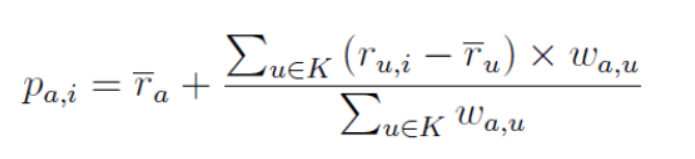

In [45]:
def score_item(neighbor_rating, similar_users_score,myRatings ):
    # aumr -> active user mean rating
    aumr = np.mean(myRatings)
    mean_neighbor_rating = np.array([np.mean(neighbor_rating[userid].dropna()) for userid in neighbor_rating.columns]).reshape(-1,1)
    data = (np.dot(similar_users_score.values.reshape(1,-1), (neighbor_rating.fillna(0).T-mean_neighbor_rating)) + aumr)/sum(similar_users_score)
    columns = neighbor_rating.T.columns
    return pd.DataFrame(data = data , columns = columns)

#### 2.2.2.2 Recommend Songs for User

In [46]:
def recommend_songs(user_id, hm):
    myRatings = userRatings.loc[:,user_id].dropna()
    similar_candidates = pd.DataFrame()
    similar_users_score = corrMatrix[user_id].sort_values(ascending=False)[:10]
    similar_users = similar_users_score.index
    neighbor_rating = userRatings[similar_users]
    similar_candidates = score_item(neighbor_rating, similar_users_score, myRatings).T
    similar_candidates.iloc[:,0],_ = score_to_counts(similar_candidates.iloc[:,0], user_id)
    # substract recommend songs that  have rated
    similar_candidates = similar_candidates[~similar_candidates.index.isin(myRatings.index)]
    similar_candidates.columns = ['pred_playcounts']
    similar_candidates.sort_values(by='pred_playcounts',inplace=True,ascending=False)    
    return similar_candidates[:hm]

# recommend movies for user_id 
rec_songs = recommend_songs(user_id='xiaolan',hm=10)
rec_songs

,pred_playcounts
trackid,
TRAALAH128E078234A,1.0
TRAEHHJ12903CF492F,1.0
TRYVBMA128E0789D39,1.0
TRYNJBB128F931A7EE,1.0
TRXWAZC128F9314B3E,1.0
TRUFTBY128F93450B8,1.0
TRSUSWW128F93463BF,1.0
TRSDRPY128F933E202,1.0
TRRUVLO128F92DE6F7,1.0


## 2.3 Collaborative filtering (CF) (Model-based Approach)

### 2.3.1 Alternating Least Squares (ALS) Implicit Data

In [47]:
# Create a numeric user_id and track_id column
data = df_user.copy()
data['userid'] = data['userid'].astype("category")
data['trackid'] = data['trackid'].astype("category")
data['user_id'] = data['userid'].cat.codes # codes are ordered by category letter
data['track_id'] = data['trackid'].cat.codes 

# The implicit library expects data as a item-user matrix so we
# create two matricies, one for fitting the model (item-user) 
# and one for recommendations (user-item)
sparse_item_user = sparse.csr_matrix((data['playcounts'].astype(float), (data['track_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['playcounts'].astype(float), (data['user_id'], data['track_id'])))

#### 2.2.3.1 Buiding ALS Model

In [48]:
# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value. 
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

# Fit the model with confidence weights
model.fit(data_conf)

# Get the user and item vectors from our trained model
user_vecs = model.user_factors
item_vecs = model.item_factors

# Calculate the vector norms
item_norms = np.sqrt((item_vecs * item_vecs).sum(axis=1))

  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------

# Find the 10 most similar to track
track_id = 'TRAEHHJ12903CF492F' 
item_id = int(data[data['trackid']== track_id]['track_id'].values[0])
n_similar = 10

# Calculate the similarity score, grab the top N items and
# create a list of item-score tuples of most similar artists
scores = item_vecs.dot(item_vecs[item_id]) / item_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / item_norms[item_id]), key=lambda x: -x[1])
top_scores = [i[1]for i in similar]

# Print the names of our most similar track
#for item in similar:
track_list = [data.trackid.loc[data.track_id == item[0]].iloc[0] for item in similar]
df_recommendItems = df_meta[(df_meta['trackid'].isin(track_list))]
# reorder the dataframe by trackid score
true_sort = [s for s in track_list if s in df_recommendItems.trackid.unique()]
df_recommendItems = df_recommendItems.set_index('trackid').loc[true_sort].reset_index()
df_recommendItems['scores'] = top_scores
df_recommendItems

,trackid,artistname,title,lyrics,scores
0,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,You're the one You're the one That made me cry...,1.000000
1,TRONYHY128F92C9D11,Kings Of Leon,Revelry,"What a night for a dance, you know I'm a danci...",0.279731
2,TROAQBZ128F9326213,OneRepublic,Secrets,I need another story Something to get off my c...,0.242427
3,TREMDNV12903CAC420,Black Eyed Peas,I Gotta Feeling,I gotta feeling That tonight's gonna be a good...,0.226964
4,TREBDEB12903CC0C56,California Swag District,Teach Me How To Dougie,They be like smooth(what?) Can you teach me ho...,0.159580
5,TRPFYYL128F92F7144,Modest Mouse,Float On,I backed my car into a cop car the other day W...,0.149183
6,TRYNJBB128F931A7EE,Eminem,Mockingbird,Yeah I know sometimes things may not always ma...,0.126695
7,TRONBHE128F92D6309,Katy Perry,I Kissed A Girl,"This was never the way I planned, not my inten...",0.117783
8,TRNTALF128EF343800,The Killers,When You Were Young,You sit there in your heartache Waiting on som...,0.117218
9,TRZJNDO128EF343498,Angels and Airwaves,The Gift,There's a strangest excitement today If you're...,0.107077


#### 2.2.3.3 Recommend Songs for User

In [50]:
def recommend(userid, num_items=10):
    """The same recommendation function we used before"""

    # Get the trained user and item vectors. We convert them to 
    # csr matrices to work with our previous recommend function.
    user_vecs = sparse.csr_matrix(model.user_factors)
    item_vecs = sparse.csr_matrix(model.item_factors)

    # Create recommendations for user with idn
    user_id = int(data[data['userid'] == userid]['user_id'].values[0])

    user_interactions = sparse_user_item[user_id, :].toarray()

    user_interactions = user_interactions.reshape(-1) + 1
    user_interactions[user_interactions > 1] = 0
    rec_vector = user_vecs[user_id, :].dot(item_vecs.T).toarray()
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1, 1))[:, 0]
    recommend_vector = user_interactions * rec_vector_scaled
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]

    tracks = []
    scores = []

    for idx in item_idx:
        tracks.append(data.trackid.loc[data.track_id == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'trackid': tracks, 'score': scores})

    return recommendations.set_index('trackid')
recommendations = recommend('xiaolan')
recommendations

,score
trackid,
TROMKCG128F9320C09,0.605665
TRYNJBB128F931A7EE,0.511816
TRQFXKD128E0780CAE,0.489389
TRBZGSM128E078EDB4,0.447690
TRJPXVB128F9316916,0.433918
TRSUSWW128F93463BF,0.420875
TRAEHHJ12903CF492F,0.409013
TRYVBMA128E0789D39,0.403571
TRLQTMK128E07810A3,0.399755


In [51]:
# check the list that user has listened
u_song_list = df_user[df_user['userid'] == userid].merge(df_meta[['trackid','artistname','title']], on = 'trackid')
display(u_song_list)

,userid,playcounts,trackid,ratings,artistname,title
0,63030d4e314e339a4609607fa7b96370cc94317b,11,TROAQBZ128F9326213,1.0,OneRepublic,Secrets
1,63030d4e314e339a4609607fa7b96370cc94317b,5,TRIEXMF128F92FDD60,0.4,Kings Of Leon,Use Somebody
2,63030d4e314e339a4609607fa7b96370cc94317b,9,TRKRRUV128F92F20F1,0.8,Train,Marry Me
3,63030d4e314e339a4609607fa7b96370cc94317b,5,TRQFXKD128E0780CAE,0.4,Coldplay,The Scientist
4,63030d4e314e339a4609607fa7b96370cc94317b,1,TRXWAZC128F9314B3E,0.0,John Mayer,Heartbreak Warfare
5,63030d4e314e339a4609607fa7b96370cc94317b,2,TRYVBMA128E0789D39,0.1,Coldplay,Fix You
6,63030d4e314e339a4609607fa7b96370cc94317b,2,TRRUVLO128F92DE6F7,0.1,La Roux,Bulletproof
7,63030d4e314e339a4609607fa7b96370cc94317b,4,TRRHGFY12903CD2DC8,0.3,Justin Bieber,Somebody To Love


### 2.2.4 Singular Value Decomposition (SVD) Explicit Data
#### 2.2.4.1 Buiding and Evaluate Model

In [52]:
df_user

,userid,playcounts,trackid,ratings
0,55a653641aa684a958e01a49442c6d4da2badd8d,3,TRAEHHJ12903CF492F,0.50
1,16ca2088a2ec137cf4597a2b3e2e0136930af8a1,6,TRAEHHJ12903CF492F,1.00
2,9f7323adccc61db1c261acf97e2468f776faaf8f,1,TRAEHHJ12903CF492F,0.00
3,39fc236a3f13ff85d27b6e9e80a40ce7bf683b27,2,TRAEHHJ12903CF492F,0.25
4,1ce57ca4746bce45d7bc3732aca5bdf3262d33be,38,TRAEHHJ12903CF492F,1.00
...,...,...,...,...
5070,206bd0676fe110325996506f393538fbf422549e,1,TRONBHE128F92D6309,0.00
5071,4397b59731ce57b91cd77200467ab079ed028941,1,TRONBHE128F92D6309,0.00
5072,xiaolan,1,TRONBHE128F92D6309,0.00
5073,xiaolan,1,TRRHGFY12903CD2DC8,0.00


In [53]:
# instantiate a reader and read in our rating data
reader = Reader()
data = Dataset.load_from_df(df_user[['userid','trackid','playcounts']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25, random_state=30)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
svd_rms = accuracy.rmse(predictions)
print(svd_rms)

RMSE: 4.9043
4.904259133566648


#### 2.2.4.2 Recommend Songs for User

In [54]:
def pred_user_rating(ui):
    if ui in df_user.userid.unique():
        ui_list = df_user[df_user.userid == ui].trackid.tolist()
        d = df_user.trackid.unique()
        d = [v for v in d if not v in ui_list] 
        predictedL = []
        for j in d:     
            predicted = algorithm.predict(ui, j)
            predictedL.append((j, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['trackid', 'pred_playcounts'])
        pdf.sort_values('pred_playcounts', ascending=False, inplace=True)  
        pdf.set_index('trackid', inplace=True)    
        return pdf.head(10)     
    else:
        print("User Id does not exist in the list!")
        return None

In [55]:
# recommend songs for user_id ''
rec_songs = pred_user_rating('xiaolan')
rec_songs

,pred_playcounts
trackid,
TRAEHHJ12903CF492F,5.000000
TRONYHY128F92C9D11,4.921245
TREBDEB12903CC0C56,3.676689
TROAQBZ128F9326213,3.508527
TRKRRUV128F92F20F1,3.223647
TRKBJPL12903CED195,3.126267
TRZJNDO128EF343498,2.889741
TRJPXVB128F9316916,2.736377
TRHTCXG12903CC2F60,2.730499
